In [38]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName('Python spark')
         .config('spark.some.config.option','some-value')
         .getOrCreate()
         )

In [60]:
df_categories = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_categories.csv", header = True, inferSchema = True)
#df_categoriesdf_cleaned = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_cleaned.csv", header = True, inferSchema = True)
df_categories.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- bath: double (nullable = true)
 |-- breakfast: double (nullable = true)
 |-- food: double (nullable = true)
 |-- internet: double (nullable = true)
 |-- location: double (nullable = true)
 |-- other: double (nullable = true)
 |-- room: double (nullable = true)
 |-- staff: double (nullable = true)



In [40]:
df_categories.head(3)

[Row(hotel='H tel Bedford', bath=0.0, breakfast=0.14343720930232556, food=0.4701666666666667, internet=-0.03997307692307694, location=0.46443679245283026, other=0.14765866983372922, room=0.10111538461538461, staff=0.3578766423357665),
 Row(hotel='Rubens At The Palace', bath=-0.009336363636363636, breakfast=0.3751626086956522, food=0.37050689655172414, internet=0.283875, location=0.4891653061224491, other=0.15908190370780295, room=0.12164440154440156, staff=0.3973766483516484),
 Row(hotel='Ayre Hotel Rosell n', bath=0.10606666666666666, breakfast=0.36541585365853657, food=0.19860909090909093, internet=0.11984000000000002, location=0.47508373493975914, other=0.16273441238564387, room=0.12104791666666667, staff=0.41171101321585907)]

In [61]:
df_categories.select('bath','location', 'room', 'internet').describe().show()

+-------+-------------------+--------------------+-------------------+-------------------+
|summary|               bath|            location|               room|           internet|
+-------+-------------------+--------------------+-------------------+-------------------+
|  count|               1056|                1489|               1490|               1308|
|   mean|0.06804403621794651| 0.42260336190093534| 0.1512505573300295|0.13403063822781167|
| stddev| 0.1754715076712679| 0.09397174728435909|0.06974481468549029|0.21013115824343884|
|    min|             -0.688|-0.20118333333333335|           -0.23835|            -0.5849|
|    max|             0.6249|              0.6249|           0.573325|             0.7764|
+-------+-------------------+--------------------+-------------------+-------------------+



# Preprocessing

In [62]:
# register table (if not exists)
try:
    df_categories.createTempView('clustering')
except:
    spark.catalog.dropTempView('clustering')
    df_categories.createTempView('clustering')

In [63]:
df_clustering = spark.sql("SELECT hotel, room, breakfast, staff, location, internet FROM clustering")
df_clustering.show()

+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|               hotel|                room|           breakfast|              staff|           location|            internet|
+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|       H tel Bedford| 0.10111538461538461| 0.14343720930232556| 0.3578766423357665|0.46443679245283026|-0.03997307692307694|
|Rubens At The Palace| 0.12164440154440156|  0.3751626086956522| 0.3973766483516484| 0.4891653061224491|            0.283875|
| Ayre Hotel Rosell n| 0.12104791666666667| 0.36541585365853657|0.41171101321585907|0.47508373493975914| 0.11984000000000002|
|        Hotel Topazz| 0.16577499999999998|0.046307407407407415|           0.357696| 0.4629949152542373| 0.43394999999999995|
|Tryp Barcelona Ap...|0.023389361702127662| 0.36012127659574467| 0.4254078431372549| 0.4163448979591837|              

In [45]:
#df_clustering = df_categories

In [64]:
FEATURES_COL = ['room', 'breakfast', 'staff', 'location', 'internet']

In [65]:
df_clustering.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- room: double (nullable = true)
 |-- breakfast: double (nullable = true)
 |-- staff: double (nullable = true)
 |-- location: double (nullable = true)
 |-- internet: double (nullable = true)



In [66]:
df_clustering.count()

1492

In [67]:
from pyspark.sql.functions import isnan, when, count, col

In [68]:
df_clustering.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clustering.columns]).show()

+-----+----+---------+-----+--------+--------+
|hotel|room|breakfast|staff|location|internet|
+-----+----+---------+-----+--------+--------+
|    0|   2|        9|    0|       3|     184|
+-----+----+---------+-----+--------+--------+



In [69]:
df = df_clustering.toDF('hotel','room', 'breakfast', 'staff', 'location', 'internet',)
print (df)
print("------------")
df.show()

DataFrame[hotel: string, room: double, breakfast: double, staff: double, location: double, internet: double]
------------
+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|               hotel|                room|           breakfast|              staff|           location|            internet|
+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+
|       H tel Bedford| 0.10111538461538461| 0.14343720930232556| 0.3578766423357665|0.46443679245283026|-0.03997307692307694|
|Rubens At The Palace| 0.12164440154440156|  0.3751626086956522| 0.3973766483516484| 0.4891653061224491|            0.283875|
| Ayre Hotel Rosell n| 0.12104791666666667| 0.36541585365853657|0.41171101321585907|0.47508373493975914| 0.11984000000000002|
|        Hotel Topazz| 0.16577499999999998|0.046307407407407415|           0.357696| 0.4629949152542373| 0.433949999999999

In [51]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+--------------------+-----------+------------+----------+----------+------------+
|               hotel|       room|   breakfast|     staff|  location|    internet|
+--------------------+-----------+------------+----------+----------+------------+
|       H tel Bedford| 0.10111538|   0.1434372|0.35787663| 0.4644368|-0.039973076|
|Rubens At The Palace|  0.1216444|   0.3751626|0.39737666| 0.4891653|    0.283875|
| Ayre Hotel Rosell n|0.121047914|  0.36541584|  0.411711|0.47508374|     0.11984|
|        Hotel Topazz|   0.165775| 0.046307407|  0.357696| 0.4629949|     0.43395|
|Tryp Barcelona Ap...|0.023389362|  0.36012128|0.42540786| 0.4163449|         0.0|
|London Marriott H...| 0.11734581|   0.2185746| 0.3684691| 0.3812402|    0.307452|
|H tel Jos phine b...| 0.06291786|     0.29523| 0.3973825|  0.489808|         0.0|
|Shaftesbury Metro...| 0.08240753|   0.2747488| 0.3545008|0.43288952|  0.25124118|
|Catalonia La Pedrera|   0.199105| 0.112204164| 0.3794082| 0.3742059|  0.20988333|
|Dou

In [52]:
#removeNa
df = df_clustering
df = df.na.drop()

In [72]:
df = df.na.drop()

In [73]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+----+---------+-----+--------+--------+
|hotel|room|breakfast|staff|location|internet|
+-----+----+---------+-----+--------+--------+
|    0|   0|        0|    0|       0|       0|
+-----+----+---------+-----+--------+--------+



In [74]:
df.count()

1306

In [75]:
from pyspark.ml.feature import VectorAssembler

In [76]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")

In [77]:
df_kmeans = vecAssembler.transform(df).select('hotel', 'features')

In [78]:
df_kmeans.show()

+--------------------+--------------------+
|               hotel|            features|
+--------------------+--------------------+
|       H tel Bedford|[0.10111538461538...|
|Rubens At The Palace|[0.12164440154440...|
| Ayre Hotel Rosell n|[0.12104791666666...|
|        Hotel Topazz|[0.16577499999999...|
|Tryp Barcelona Ap...|[0.02338936170212...|
|London Marriott H...|[0.11734581280788...|
|H tel Jos phine b...|[0.06291785714285...|
|Shaftesbury Metro...|[0.08240752864157...|
|Catalonia La Pedrera|[0.199105,0.11220...|
|DoubleTree by Hil...|[0.14735642201834...|
|Best Western Hote...|[0.13620000000000...|
|      Hotel Corvinus|[0.13417894736842...|
|Austria Trend Hot...|[0.12402523364485...|
|The One Barcelona GL|[0.15030555555555...|
|Hotel Johann Strauss|[0.17711315789473...|
|Austria Trend Hot...|[0.16377,0.379414...|
|Park Inn by Radis...|[0.11713962264150...|
|          Park Hotel|[0.14164779116465...|
|   Plaza Tour Eiffel|[0.16251363636363...|
|     Hotel Maison FL|[0.1279878

# K-means

In [79]:
from pyspark.ml.clustering import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

Text(0,0.5,'cost')

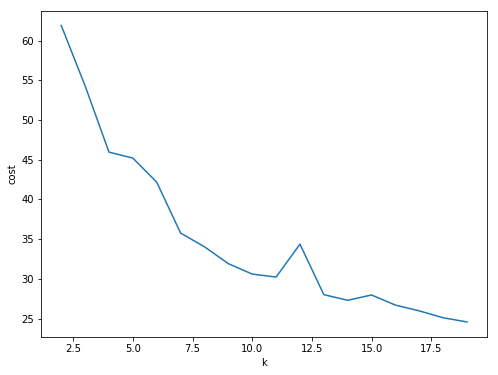

In [81]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [147]:
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 0.13813209  0.23018875  0.35220906  0.43955043  0.16589331 -0.02552035]
[0.15883321 0.22493329 0.36281024 0.42873242 0.13325853 0.36380294]
[0.15814909 0.22712864 0.36911003 0.44749857 0.37138098 0.06168584]
[ 0.14506578  0.21192908  0.34775694  0.435491   -0.07885633  0.02867991]
[0.17120799 0.27115628 0.31125406 0.1887187  0.20775327 0.03717185]


In [148]:
wssse = model.computeCost(df_kmeans)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 38.65250929480997


In [149]:
transformed = model.transform(df_kmeans).select('hotel', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(hotel='H tel Bedford', prediction=3), Row(hotel='Rubens At The Palace', prediction=2), Row(hotel='Ayre Hotel Rosell n', prediction=0)]


In [150]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+--------------------+----------+
|               hotel|prediction|
+--------------------+----------+
|       H tel Bedford|         3|
|Rubens At The Palace|         2|
| Ayre Hotel Rosell n|         0|
|Tryp Barcelona Ap...|         0|
|London Marriott H...|         2|
|H tel Jos phine b...|         3|
|Catalonia La Pedrera|         0|
|DoubleTree by Hil...|         1|
|Best Western Hote...|         0|
|The One Barcelona GL|         3|
|Hotel Johann Strauss|         2|
|Park Inn by Radis...|         0|
|          Park Hotel|         2|
|        Hotel Balmes|         3|
|DoubleTree by Hil...|         0|
|Rydges Kensington...|         2|
|IH Hotels Milano ...|         4|
|Radisson Blu Edwa...|         0|
|Hotel Boutique Duomo|         4|
|  The Langham London|         2|
+--------------------+----------+
only showing top 20 rows



In [151]:
df_pred = df_pred.join(df, 'hotel')
df_pred.show()

+--------------------+----------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+
|               hotel|prediction|                bath|          breakfast|                food|            internet|           location|              other|                room|              staff|
+--------------------+----------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+
|       H tel Bedford|         3|                 0.0|0.14343720930232556|  0.4701666666666667|-0.03997307692307694|0.46443679245283026|0.14765866983372922| 0.10111538461538461| 0.3578766423357665|
|Rubens At The Palace|         2|-0.00933636363636...| 0.3751626086956522| 0.37050689655172414|            0.283875| 0.4891653061224491|0.15908190370780295| 0.12164440154440156| 0.3973766483516484|
| Ayre Hot

# Plot results

In [152]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [153]:
df_pred2 = df_pred.toPandas().set_index('hotel')
df_pred2.head()

,prediction,bath,breakfast,food,internet,location,other,room,staff
hotel,,,,,,,,,
H tel Bedford,3,0.000000,0.143437,0.470167,-0.039973,0.464437,0.147659,0.101115,0.357877
Rubens At The Palace,2,-0.009336,0.375163,0.370507,0.283875,0.489165,0.159082,0.121644,0.397377
Ayre Hotel Rosell n,0,0.106067,0.365416,0.198609,0.119840,0.475084,0.162734,0.121048,0.411711
Tryp Barcelona Apolo Hotel,0,-0.688000,0.360121,0.098540,0.000000,0.416345,0.047367,0.023389,0.425408
London Marriott Hotel Regents Park,2,0.133967,0.218575,0.303471,0.307452,0.381240,0.110230,0.117346,0.368469


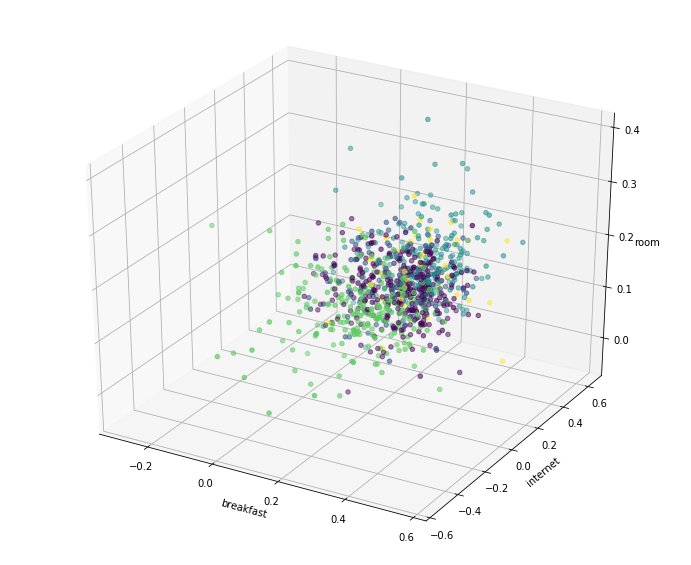

In [155]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(df_pred2.breakfast, df_pred2.internet ,df_pred2.room, c=df_pred2.prediction)
threedee.set_xlabel('breakfast')
threedee.set_ylabel('internet')
threedee.set_zlabel('room')
#threedee.set_klabel('staff')
plt.show()

In [156]:
#source https://rsandstroem.github.io/sparkkmeans.html

In [157]:
FEATURES_COL

['room', 'breakfast', 'staff', 'location', 'internet', 'bath']

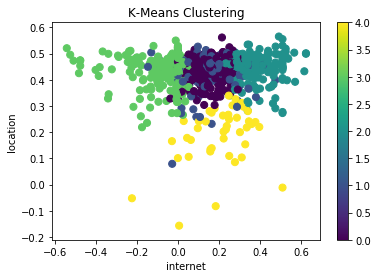

In [163]:
fig = plt.figure()
x = 'internet'
y = 'location'


ax = fig.add_subplot(111)
scatter = ax.scatter(df_pred2[x],df_pred2[y],
                   c=df_pred2.prediction,s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.colorbar(scatter)

In [132]:
categories=list(df_pred2)[1:]
categories

['bath', 'breakfast', 'food', 'internet', 'location', 'other', 'room', 'staff']

In [227]:
df_pred.show()

+--------------------+----------+--------------------+--------------------+-------------------+-------------------+--------------------+
|               hotel|prediction|                room|           breakfast|              staff|           location|            internet|
+--------------------+----------+--------------------+--------------------+-------------------+-------------------+--------------------+
|       H tel Bedford|         2| 0.10790337078651686| 0.14343720930232556| 0.3637463235294117| 0.4644367924528302|-0.05614814814814815|
|Rubens At The Palace|         5|        0.1203984375| 0.36697815126050426|  0.398471349862259| 0.4886692307692308|            0.283875|
| Ayre Hotel Rosell n|         5| 0.12104791666666667|  0.3730188235294118| 0.4130189427312775|0.47508373493975903| 0.11984000000000002|
|        Hotel Topazz|         7|  0.1792162162162162|  0.0463074074074074|0.36428133333333323|0.46299491525423725| 0.43394999999999995|
|Tryp Barcelona Ap...|         0| 0.04172

In [229]:
# register table (if not exists)
try:
    df_pred.createTempView('plots')
except:
    spark.catalog.dropTempView('plots')
    df_pred.createTempView('plots')

In [230]:
df_kmeans_average = spark.sql("SELECT prediction as cluster, avg(room), avg(breakfast), avg(staff), avg(location), avg(internet) FROM plots group by prediction")

In [166]:
df_kmeans_average.show()

NameError: name 'df_kmeans_average' is not defined

In [232]:
df_kmeans_average2 = df_kmeans_average.toPandas().set_index('cluster')
df_kmeans_average2

,avg(room),avg(breakfast),avg(staff),avg(location),avg(internet)
cluster,,,,,
0,0.145470,0.309162,0.363607,0.428636,0.014868
7,0.129091,0.042516,0.362370,0.448988,0.300738
6,0.143186,0.184395,0.347443,0.433854,0.145552
9,0.219579,0.471241,0.426597,0.285600,-0.381717
5,0.153884,0.327709,0.369091,0.423543,0.216299
1,0.145367,0.245205,0.369334,0.449712,0.314964
10,0.178103,0.261163,0.364466,0.399756,0.481664
3,0.155270,0.204791,0.363571,0.458666,-0.442468
8,0.140085,0.241970,0.337080,0.416891,-0.163928


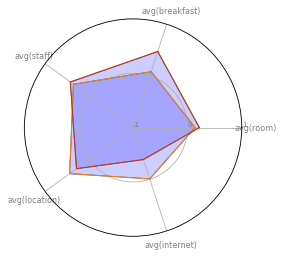

In [247]:
from math import pi
 
#number of variable
categories=list(df_kmeans_average2)[0:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df_kmeans_average2.loc[2].values.flatten().tolist()
values += values[:1]
values

values2=df_kmeans_average2.loc[2].values.flatten().tolist()
values2 += values2[:1]
values2

values3=df_kmeans_average2.loc[9].values.flatten().tolist()
values3 += values3[:1]
values3

values4=df_kmeans_average2.loc[9].values.flatten().tolist()
values4 += values4[:1]
values4

 
#What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-1,0,1], ["-1","0","1"], color="grey", size=7)
plt.ylim(-1,1)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.plot(angles, values2, linewidth=1, linestyle='solid')
ax.plot(angles, values3, linewidth=1, linestyle='solid')
ax.plot(angles, values4, linewidth=1, linestyle='solid')


 
 
#Fill area
ax.fill(angles, values, 'b', alpha=0.1)
ax.fill(angles, values2, 'b', alpha=0.1)
ax.fill(angles, values3, 'b', alpha=0.1)
ax.fill(angles, values4, 'b', alpha=0.1)